In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np

from tqdm.notebook import trange, tqdm

from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')
depth = Path('../GTA_images/Simple/Depth')

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    import_raw_depth_image, 
    show_img,
    show_array_of_images
)

from Feature_Extraction import (
    create_feature_vector,
    process_patches
)

# Local Absolute Depth

## Equation

Our goal is to create parameters for the function:

$$d_i = \theta_r x_i$$

We do this using the Gaussian equation below:

$$P(d|X;\theta;\sigma_{1r}) = \frac{1}{Z}\exp{\left({-\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right)}$$

## Variables

| Variables |Description|
|-|-|
|$P(d|X)$|probable depth d given image features X|
|$\theta$|parameter calculated during training|
| Z | Normalisation constant |
| M | Number of patches |
|$d_i$|depth at a given patch|
|$x_i$|feature vector at patch|


## Training

### Equations

In training our goal is to determine $\theta$, this is done by maximising the value l(d):

 $$l(d) = \log{P(d|X;\theta_r)}$$


 $$l(d) = \log\left(\frac{1}{Z}\right)\left({-\sum_\limits{i=1}^{M}d_i-\theta_r x_i^T}\right)$$

Linear least squares is used to determine the value of $\theta$ that will maximise l(d), which occurs as:

$$\left({\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right) \rightarrow 0$$

$\therefore$ we can find the least square of the equation:

$$d_i = \theta_rx_i^T$$

In [2]:
from scipy import optimize

def function(x, *𝜃):
    return x @ np.array(𝜃)

def least_squares(features, depth, 𝜃):
    return optimize.curve_fit(function, 
                              xdata=features.reshape(-1, features.shape[-1]), 
                              ydata=depth.flatten(),
                              p0=𝜃)

## Example

### Training Image

In [3]:
sorted(colour.iterdir())

[PosixPath('../GTA_images/Simple/Colour/color_1.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_2.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_3.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_4.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_5.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_6.raw')]

In [4]:
colour_images = [import_raw_colour_image(str(file)) for file in sorted(colour.iterdir())]
depth_images = [import_raw_depth_image(str(file)) for file in sorted(depth.iterdir())]

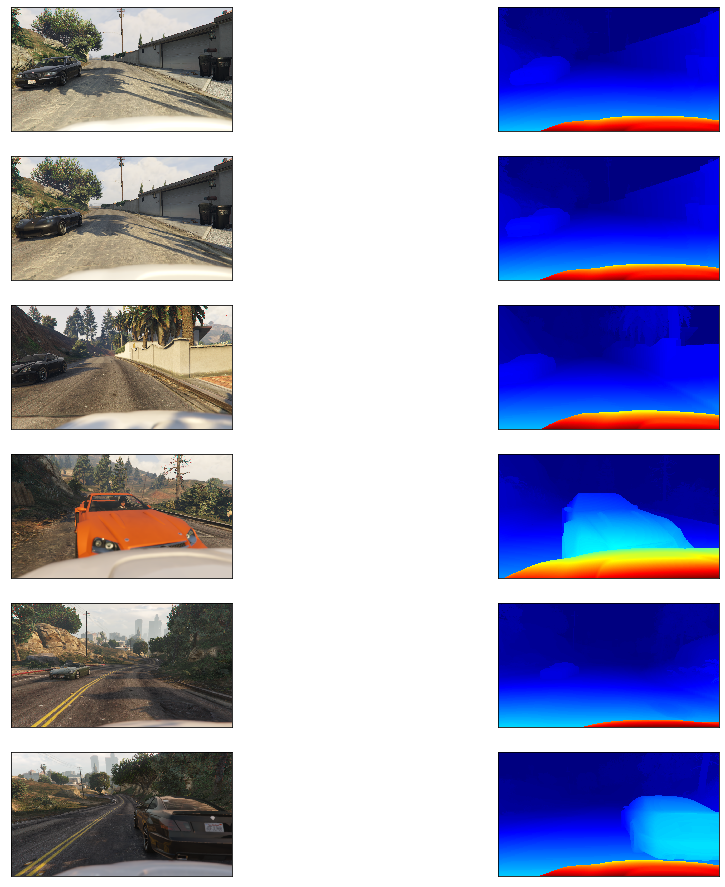

In [13]:
show_array_of_images([x for y in zip(colour_images, depth_images) for x in y], 
                     shape=(6,2), depthmap=True)

### Get the feature values of each patch

In [6]:
from tqdm.notebook import tqdm

features_6x6 = [process_patches(image, (6,6), function=create_feature_vector)
                for image in tqdm(colour_images, total=6, leave=False)]

### Mean the depth values accross each patch

In [7]:
depths_6x6 = [process_patches(image,(6,6),function=np.mean)
              for image in tqdm(depth_images, total=6, leave=False)]

### Set an estimate for $\theta$: 
required as otherwise scipy will assume it is a scalar

In [8]:
𝜃 = [1 for i in range(features_6x6[0].shape[-1])]

### Train accross each of first five images

In [9]:
for feature, depth in tqdm(zip(features_6x6[:-1], depths_6x6[:-1]),
                           total=len(features_6x6[:-1]), leave=False):
    𝜃,_ = least_squares(feature,  depth, 𝜃)

In [68]:
import math

mean, std = np.mean(𝜃), np.std(𝜃)

𝜃_stand = [(weight-mean)/std for weight in 𝜃] 
𝜃_stand

[1.5099584452733668,
 1.8556818141984237,
 1.1950496545196077,
 -0.3738697030782978,
 -0.2647057401421586,
 1.7103458994727445,
 0.2731455080084449,
 -2.7453069059838717,
 -3.821316175402886,
 -0.44061432506188797,
 0.7862967800893643,
 0.022081105991875058,
 -0.1610681415827188,
 0.04554249008589383,
 0.09377027382397483,
 0.05996238802103484,
 -0.0768916343399057,
 0.013667530024382406,
 0.011323008016916518,
 0.01641751437938357,
 -0.32040587559664185,
 -0.10801738714077787,
 0.011564251197689102,
 -0.3078747752287424,
 0.046831487831732785,
 0.05333751190049683,
 0.026613076344200202,
 0.01712001414663074,
 -0.22983019056031276,
 -0.07058646245836886,
 0.1791594343061724,
 0.270299598882465,
 0.345317285316058,
 0.37700224474571115]

In [18]:
import matplotlib.pyplot as plt

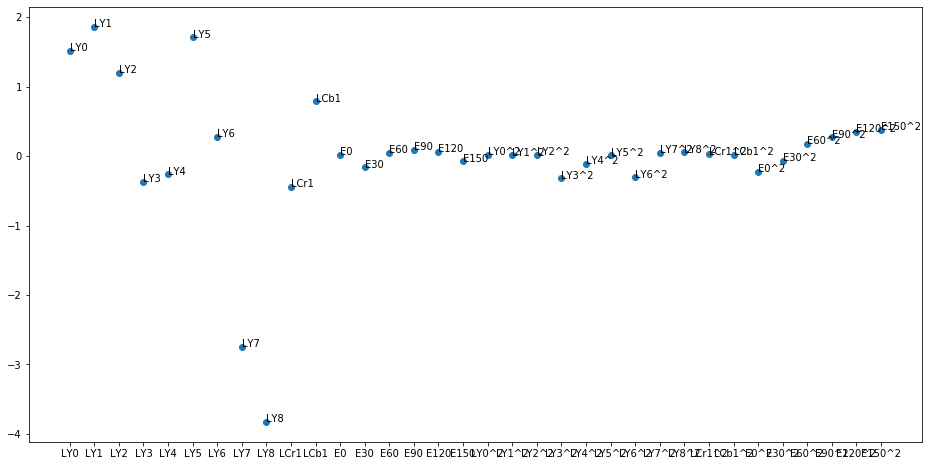

In [71]:
_, axis = plt.subplots(1,1,figsize=(16,8))

features = [f"LY{i}" for i in range(9)] + ["LCr1", "LCb1"] + [f"E{i}" for i in range(0,180,30)]

total = features + [f"{f}^2" for f in features]

axis.scatter(total, 𝜃_stand)

for x,y in enumerate(𝜃_stand):
    axis.annotate(total[x], xy=(x,y))

### Predict the depth for the final image

In [11]:
predicted_depth = features_6x6[-1] @ 𝜃

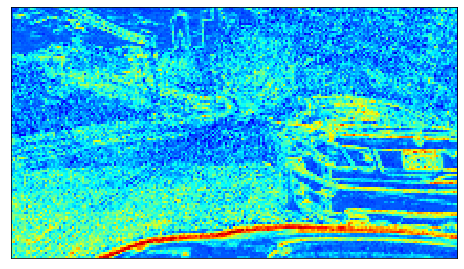

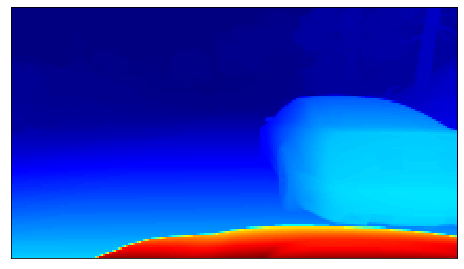

In [14]:
show_img(predicted_depth, depthmap=True)
show_img(depths_6x6[-1], depthmap=True)